In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow_addons as tfa

In [2]:
data_path = Path('../data')

In [3]:
os.listdir(data_path)

['tbd_17_part_0.npy',
 'tbd_17_part_2.npy',
 'RGB_19_2_wet.mat',
 'tbd_17_part_5.npy',
 'tbd_17_part_6.npy',
 'TDWB_19_2_chanMaps.mat',
 'TDWB_19_2_SLOPE.mat',
 'tbd_17_part_3.npy',
 'TDB_17_data.mat',
 'tbd_17_part_1.npy',
 'ZD_19_2_wet.mat',
 'TDB_13_data.mat',
 'tbd_17_part_4.npy']

## test run with just one batch of data

In [4]:
npy_files = [f for f in os.listdir(data_path) if f.endswith('.npy')]

data = []
for f in npy_files[:1]:
    data.append(np.load(data_path / f).astype(int))

In [5]:
data = np.concatenate(data)

In [6]:
data.shape

(100, 796, 522, 5)

In [7]:
data_tensor = tf.convert_to_tensor(data)

In [13]:
image = data_tensor[0, :, :, -1:]
image.shape

TensorShape([796, 522, 1])

In [14]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

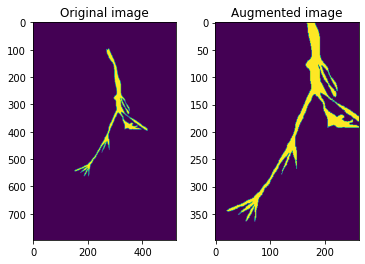

In [15]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

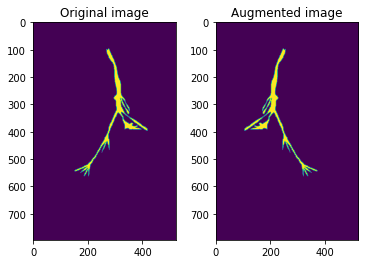

In [16]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

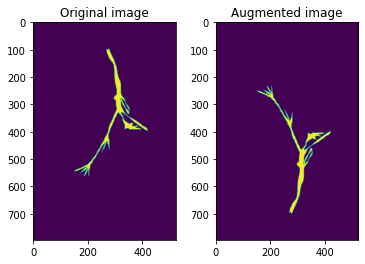

In [17]:
flipped = tf.image.flip_up_down(image)
visualize(image, flipped)

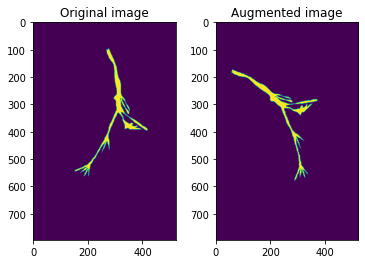

In [20]:
flipped = tfa.image.rotate(image, angles=np.pi/4)
visualize(image, flipped)

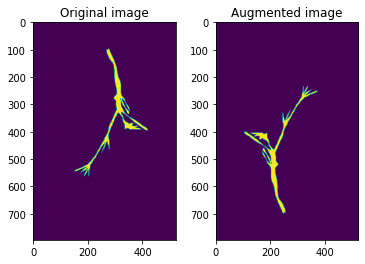

In [23]:
flipped = tfa.image.rotate(image, angles=np.pi)
visualize(image, flipped)

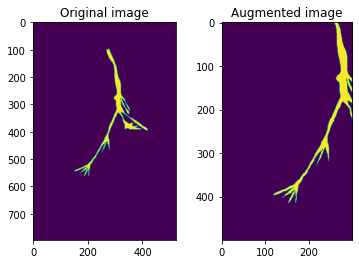

In [26]:
cropped = tf.image.random_crop(
    image, [500, 300, 1], seed=None, name=None
)
visualize(image, cropped)

### augmentation to perform

Due to the nature of segmentation we only use center crop, flipping, and random rotation to augment the dataset. We can also use random cropping of a given window size (which is just a lateral translation). All those augmentation steps are rigit body transformations. 

We perform the augmentation in batches and save the result images and masks (labels) as files.

In [31]:
images = data_tensor[:2, :, :, -1:]
images.shape

TensorShape([2, 796, 522, 1])

In [52]:
image_path = data_path / 'images'
mask_path = data_path / 'masks'
batch_size = 20
img_height, img_width = 500, 300

In [56]:
n_batch = np.ceil(data_tensor.shape[0] / batch_size).astype(int)
seeds = np.random.randint(0, 10000, n_batch)

for i in range(1):
    batch_data = data_tensor[
        i*batch_size : min(data_tensor.shape[0], (i+1)*batch_size)
    ]
    np.random.seed(seeds[i])
    angles = np.pi * np.random.randint(0, 360, batch_size) / 180
    rotated = tfa.image.rotate(batch_data, angles=angles)
    cropped = tf.image.random_crop(rotated, [batch_size, img_height, img_width, 5], seed=None, name=None)

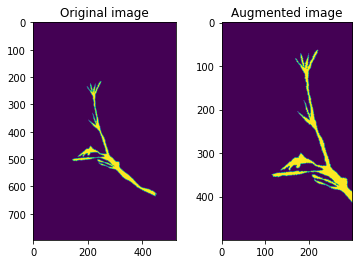

In [49]:
visualize(rotated[2,:,:,-1], cropped[2,:,:,-1])

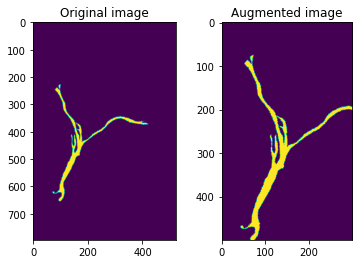

In [50]:
visualize(rotated[5,:,:,-1], cropped[5,:,:,-1])

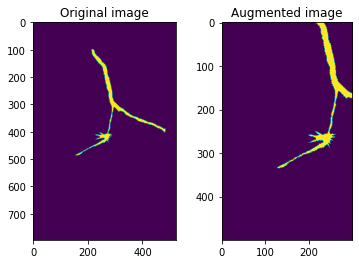

In [51]:
visualize(rotated[10,:,:,-1], cropped[10,:,:,-1])

## teste batch processing with all data

It turns out all the image data can be too large for the memory to process so we have to save the data in batches as TFRecords. We can't save them as images because 1) channel size limit; 2) image have rules about values in each channel.

In [57]:
npy_files = [f for f in os.listdir(data_path) if f.endswith('.npy')]

data = []
for f in npy_files:
    writer = tf.py
    np.load(data_path / f).astype(int)

In [7]:
dslice = tf.data.Dataset.from_tensor_slices(data)

In [28]:
def crop_image(image, idx=0, img_height=500, img_width=300, img_channel=5):
    cropped = tf.image.random_crop(
        image, [img_height, img_width, img_channel], 
        seed=None, name=None
    )
    return cropped


def save_crops(tensor, prefix='', batch=0, idx=0, path=Path('.')):
    prefix += f'batch_{batch}_num_{idx}_'
    tf.keras.preprocessing.image.save_img(
        path / (prefix + 'image.png'), tensor[:, :, :3]
    )
    tf.keras.preprocessing.image.save_img(
        path / (prefix + 'elevation.png'), tensor[:, :, 3:4]
    )
    tf.keras.preprocessing.image.save_img(
        path / (prefix + 'mask.png'), tensor[:, :, 4:]
    )

In [15]:
cropped_slices = (
    dslice
        .shuffle(1000)
        .map(crop_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .batch(10)
        .prefetch(tf.data.experimental.AUTOTUNE)
)

In [21]:
cropped = list(cropped_slices.take(1).as_numpy_iterator())

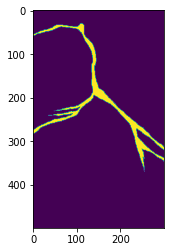

In [23]:
plt.imshow(cropped[0][0,:,:,-1])

In [30]:
for i, batch in enumerate(cropped):
    for j, image in enumerate(batch):
        save_crops(image, batch=i, idx=j, path=data_path / 'crops')

In [32]:
for i, batch in enumerate(cropped_slices):
    print(f'batch {i}')

batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
